## Transformer on Machine Translation 

## Imports 

In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline 

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import os 

In [4]:
import math
import torch
from torch import nn
from torch.nn import functional as F

In [5]:
from omd2l.data.TimeMachine import TimeMachine


In [6]:
from omd2l.models.RNN import RNNScratch
from omd2l.models.RNN import RNNLMScratch
from omd2l.data import TimeMachine
from omd2l.models.base import Trainer


In [7]:
from omd2l.models.RNN import BiRNNScratch
from omd2l.models.RNN  import BiRNN


In [8]:
from omd2l.models.RNN import LSTMScratch
from omd2l.models.RNN import LSTM

In [9]:
from omd2l.models.RNN import GRUScratch
from omd2l.models.RNN import GRU

In [10]:
from omd2l.models.RNN import RNN
from omd2l.models.RNN import RNNLM

In [11]:
from omd2l.models.RNN import StackedRNNScratch


In [12]:
from omd2l.models.Transformer import TransformerEncoder
from omd2l.models.Transformer import TransformerDecoder
from omd2l.models.Seq2Seq.Seq2Seq import Seq2Seq


In [13]:
from omd2l.evaluate import bleu

In [14]:
from omd2l.data.MTFraEng import MTFraEng 

In [15]:
from omd2l.utils.compute import try_gpu

In [16]:
from omd2l.utils.display import  * 

## Load data

In [17]:
data = MTFraEng(batch_size=10)
raw_text = data._download()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [18]:
text = data._preprocess(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [19]:
src, tgt = data._tokenize(text)
src[:6], tgt[:6]

([['go', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['run', '!', '<eos>'],
  ['run', '!', '<eos>'],
  ['who', '?', '<eos>'],
  ['wow', '!', '<eos>']],
 [['va', '!', '<eos>'],
  ['salut', '!', '<eos>'],
  ['cours', '!', '<eos>'],
  ['courez', '!', '<eos>'],
  ['qui', '?', '<eos>'],
  ['ça', 'alors', '!', '<eos>']])

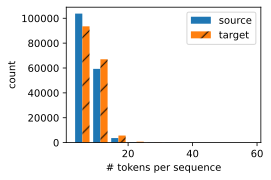

In [20]:
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', src, tgt);

In [21]:
data = MTFraEng(batch_size=3)
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print('source:', src.type(torch.int32))
print('decoder input:', tgt.type(torch.int32))
print('source len excluding pad:', src_valid_len.type(torch.int32))
print('label:', label.type(torch.int32))

source: tensor([[ 65,  55,   2,   3,   4,   4,   4,   4,   4],
        [ 86,  20,   2,   3,   4,   4,   4,   4,   4],
        [130,   6,   3,   4,   4,   4,   4,   4,   4]], dtype=torch.int32)
decoder input: tensor([[  3,   6,  30,   0,   4,   5,   5,   5,   5],
        [  3, 108, 183, 136,   2,   4,   5,   5,   5],
        [  3,   6,  33,   7,   4,   5,   5,   5,   5]], dtype=torch.int32)
source len excluding pad: tensor([4, 4, 3], dtype=torch.int32)
label: tensor([[  6,  30,   0,   4,   5,   5,   5,   5,   5],
        [108, 183, 136,   2,   4,   5,   5,   5,   5],
        [  6,  33,   7,   4,   5,   5,   5,   5,   5]], dtype=torch.int32)


In [22]:
src, tgt, _,  _ = data.build(['hi .'], ['salut .'])
print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


## Transformer

In [23]:
num_hiddens, num_blks, dropout = 256, 8, 0.01
ffn_num_hiddens, num_heads = 10, 2

In [24]:
 

encoder = TransformerEncoder(len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,num_blks, dropout)




/Users/oualid/opt/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [25]:
decoder = TransformerDecoder(len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,num_blks, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],lr=0.001)

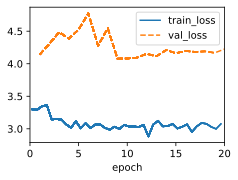

In [26]:
trainer = Trainer(max_epochs=20, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [27]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => [], bleu,0.000
i lost . => [], bleu,0.000
he's calm . => [], bleu,0.000
i'm home . => [], bleu,0.000
